In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_validate, LeaveOneOut, KFold, train_test_split

import logging
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import seaborn as sns
sns.set_theme(style="whitegrid")
mpl.style.use('seaborn-notebook')

#import mlflow
#mlflow.set_tracking_uri("http://mlflow_server:5000/")
#mlflow.set_experiment("/archimedes-ml")
# enable autologging
#mlflow.sklearn.autolog()

In [3]:
score = 'accuracy'

#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_data_augmentation_radius_20220827.csv") #TODO automate
features = features.set_index(features.columns[0])
labels = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_data_augmentation_radius_20220827_labels.csv") #TODO automate
labels = labels.set_index(labels.columns[0])
print("Loaded data from CSV")
features.head(10)

Loaded data from CSV


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
C01_1,3.527737e-13,-137.440209,-8.198945,78.949506,15.312816,-48.835657,-10.701902,41.748265,18.772267,-24.300636,...,28.658705,26.089212,15.809809,17.826344,28.928074,29.779980,21.489811,22.632341,33.965646,37.642997
C01_1,-1.374402e+02,-8.198945,78.949506,15.312816,-48.835657,-10.701902,41.748265,18.772267,-24.300636,-8.824869,...,26.089212,15.809809,17.826344,28.928074,29.779980,21.489811,22.632341,33.965646,37.642997,30.991587
C01_1,-8.198945e+00,78.949506,15.312816,-48.835657,-10.701902,41.748265,18.772267,-24.300636,-8.824869,30.008777,...,15.809809,17.826344,28.928074,29.779980,21.489811,22.632341,33.965646,37.642997,30.991587,30.789951
C01_1,7.894951e+01,15.312816,-48.835657,-10.701902,41.748265,18.772267,-24.300636,-8.824869,30.008777,22.580910,...,17.826344,28.928074,29.779980,21.489811,22.632341,33.965646,37.642997,30.991587,30.789951,41.249421
C01_1,1.531282e+01,-48.835657,-10.701902,41.748265,18.772267,-24.300636,-8.824869,30.008777,22.580910,-9.773901,...,28.928074,29.779980,21.489811,22.632341,33.965646,37.642997,30.991587,30.789951,41.249421,46.564851
C01_1,-4.883566e+01,-10.701902,41.748265,18.772267,-24.300636,-8.824869,30.008777,22.580910,-9.773901,-5.203928,...,29.779980,21.489811,22.632341,33.965646,37.642997,30.991587,30.789951,41.249421,46.564851,40.982118
C01_1,-1.070190e+01,41.748265,18.772267,-24.300636,-8.824869,30.008777,22.580910,-9.773901,-5.203928,24.815867,...,21.489811,22.632341,33.965646,37.642997,30.991587,30.789951,41.249421,46.564851,40.982118,39.132995
C01_1,4.174827e+01,18.772267,-24.300636,-8.824869,30.008777,22.580910,-9.773901,-5.203928,24.815867,24.993476,...,22.632341,33.965646,37.642997,30.991587,30.789951,41.249421,46.564851,40.982118,39.132995,48.084052
C01_1,1.877227e+01,-24.300636,-8.824869,30.008777,22.580910,-9.773901,-5.203928,24.815867,24.993476,-0.674980,...,33.965646,37.642997,30.991587,30.789951,41.249421,46.564851,40.982118,39.132995,48.084052,54.351784


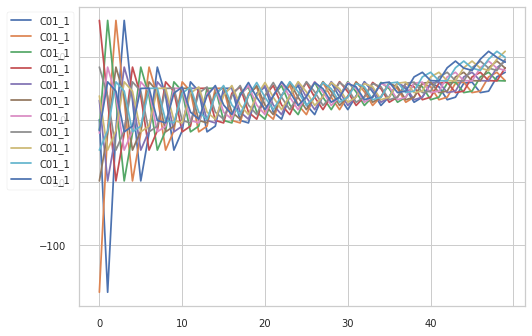

In [6]:
from matplotlib import pyplot as plt

ax=features.loc['C01_1'][0:11].T.plot()
ax.legend(bbox_to_anchor=(0, 1))

In [4]:
features.loc['C01_1'].shape

(4047, 50)

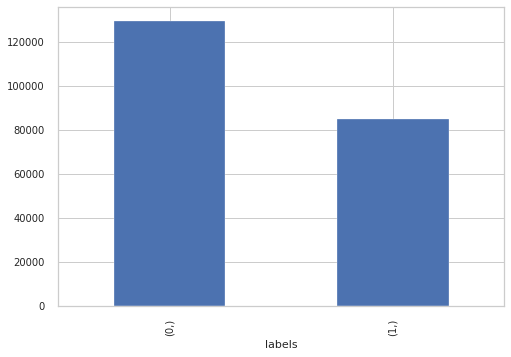

In [5]:
_=labels.value_counts().plot.bar()

In [6]:
labels.count()

labels    214491
dtype: int64

In [7]:
le = LabelEncoder().fit(labels.values.ravel())
logging.info("Classes {}".format(le.classes_))
y = LabelEncoder().fit_transform(labels.values.ravel())
y.shape

(214491,)

In [8]:
X=features.values
X.shape

(214491, 50)

In [9]:
features

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
C01_1,7.349452e-15,-13.291940,1.024601,10.161138,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,...,8.309032,7.649810,6.732932,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316
C01_1,-1.329194e+01,1.024601,10.161138,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,...,7.649810,6.732932,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390
C01_1,1.024601e+00,10.161138,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,7.796532,...,6.732932,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240
C01_1,1.016114e+01,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,7.796532,7.401986,...,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966
C01_1,3.315941e+00,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,7.796532,7.401986,4.388565,...,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966,13.660017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T029,1.605690e+03,1617.369786,1623.302563,1633.450707,1636.838510,1646.346104,1649.546574,1652.648824,1658.428228,1656.413774,...,1711.844431,1721.671417,1724.539759,1748.846339,1735.802846,1762.870175,1750.176319,1761.904180,1770.923177,1740.136643
T029,1.617370e+03,1623.302563,1633.450707,1636.838510,1646.346104,1649.546574,1652.648824,1658.428228,1656.413774,1662.122235,...,1721.671417,1724.539759,1748.846339,1735.802846,1762.870175,1750.176319,1761.904180,1770.923177,1740.136643,1805.874112
T029,1.623303e+03,1633.450707,1636.838510,1646.346104,1649.546574,1652.648824,1658.428228,1656.413774,1662.122235,1659.848505,...,1724.539759,1748.846339,1735.802846,1762.870175,1750.176319,1761.904180,1770.923177,1740.136643,1805.874112,1697.014063


In [10]:
model_switcher = {
    'lda': LDA(),
    'random_forest': RandomForestClassifier(n_estimators=30),
    'knn': KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='euclidean'),
    'svm': SVC(kernel='rbf', gamma=0.2, C=10**3)
}

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=38)
#model = model_switcher['knn']
for key in model_switcher: 
    model = model_switcher[key]
    model.fit(X_train, Y_train)
    result = model.score(X_test, Y_test)
    print("{} test accuracy: {}".format(key, result*100.0))

lda test accuracy: 60.466496192588615
random_forest test accuracy: 93.41508554313889


In [ ]:
predictions = pd.DataFrame(model_switcher['random_forest'].predict(features), columns=['prediction'])
predictions['suj'] = features.index
predictions.sample(3)

In [ ]:
predictions.groupby('suj').prediction.apply(list)